In [1]:
import pandas as pd
import spacy

from google.colab import drive 
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Capstone/Scripts/NLP_part/')


/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


MessageError: ignored

In [ ]:
df_listing =pd.read_csv(r'../../Data/LA_Airbnb/listings_detailed.csv')

In [ ]:
df_listing.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,65467,https://www.airbnb.com/rooms/65467,20221206172243,2022-12-07,city scrape,A Luxury Home in Los Angeles,<b>The space</b><br />Private 16 x 15 ft room ...,NaN,https://a0.muscache.com/pictures/821696/64d8a6...,61864,...,NaN,NaN,NaN,NaN,f,2,0,2,0,NaN
1,206662,https://www.airbnb.com/rooms/206662,20221206172243,2022-12-07,city scrape,"Hollywood & Hiking, 30 day minimum","Semi-Private, vaccinated only, you will be sta...",The quietest part of Hollywood yet still walka...,https://a0.muscache.com/pictures/30274679/5011...,33861,...,4.92,4.92,4.87,NaN,f,1,0,1,0,0.71
2,67089,https://www.airbnb.com/rooms/67089,20221206172243,2022-12-07,city scrape,Tranquil Guesthouse Oasis with a Hot Tub,Relax in a hammock or hot tub in a secluded ba...,The bungalow sits behind the main house down t...,https://a0.muscache.com/pictures/87cd0874-9acc...,210344,...,4.94,4.91,4.87,NaN,f,2,2,0,0,4.80
3,210489,https://www.airbnb.com/rooms/210489,20221206172243,2022-12-07,city scrape,3br 3ba townhome near Beverly Hills,"Beverly Hills area, very safe, quiet and centr...",Great neighborhood! Two blocks to Beverly Hil...,https://a0.muscache.com/pictures/7589741/7e3fc...,76111,...,4.93,4.43,4.64,Exempt - This listing is a transient occupancy...,f,2,1,1,0,0.14
4,109,https://www.airbnb.com/rooms/109,20221206172243,2022-12-07,city scrape,Amazing bright elegant condo park front *UPGRA...,"*** Unit upgraded with new bamboo flooring, br...",NaN,https://a0.muscache.com/pictures/4321499/1da98...,521,...,4.00,5.00,4.00,NaN,f,1,1,0,0,0.01


In [ ]:
df_listing.shape

(40438, 75)

In [ ]:
#convert the price to float type
df_listing["price_"] =df_listing['price'].str.extract("(\d+)")

In [ ]:
df_listing["price_"] = df_listing["price_"].astype('float')

In [ ]:
# load pretrained_model
nlp=spacy.load("en_core_web_lg")

In [ ]:
#fillna
df_listing["description"] = df_listing["description"].fillna(" ") 

In [ ]:
def extract_ner(sentence):
    # Process the input text with the NER component
    if sentence:
        doc = nlp(sentence)
        LOCs = []
        # Print the named entities and their labels
        for ent in doc.ents:
            if ent.label_ in ["FAC","LOC","ORG"]:
                # print(ent.text)
                LOCs.append(ent.text)
        return LOCs

import re
# there are some block need to be removed.
def replace_br(locs):
    newlocs=[]
    for loc in locs:
        loc =re.sub('<br /><br /><b',"",loc)
        loc =re.sub('<br />',"",loc)
        loc =re.sub('<br /><br />',"",loc)
        loc =re.sub('<br',"",loc)
        loc =re.sub('/>',"",loc)
        
        newlocs.append(loc)
    return newlocs

# some name need to be unified
def drop_stop(loc):
    new_loc = []
    for word in loc:
        if word not in ['The','the']:
            new_loc.append(word.lower().rstrip('s'))
    return new_loc

In [ ]:
from tqdm import tqdm
from collections import Counter
loc_description = []
ner_count = Counter()
for index,line in tqdm(df_listing.iterrows(), total=len(df_listing)):
  ner_list = extract_ner(line["description"])
  ner_list = replace_br(ner_list)
  ner_list = drop_stop(ner_list)
  for ner in ner_list:
    ner_count[ner]+=1
  loc_description.append(ner_list)


100%|██████████| 40438/40438 [15:06<00:00, 44.61it/s]


In [ ]:
df_listing["loc_description_all_ner"] = loc_description

In [ ]:
len(ner_count)

25064

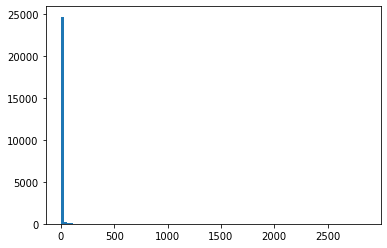

In [ ]:
import matplotlib.pyplot as plt
plt.hist(ner_count.values(),bins=100)
plt.show()

In [ ]:
#### only include NERs mentioned more than 10 times and less than 500 times
filtered_ner_count = {i:ner_count[i] for i in ner_count.keys() if ner_count[i]>20 and ner_count[i]<500}
len({i:ner_count[i] for i in ner_count.keys() if ner_count[i]>20 and ner_count[i]<500})

598

In [ ]:
####
df_listing['loc_description_filtered_ner'] = [[k for k in i if k in filtered_ner_count.keys()] \
                                                      for i in df_listing['loc_description_all_ner'].values]


In [ ]:
# explode the extraction so that we can agg by single LOC Or FAC
list_loc =df_listing[['id',"loc_description_filtered_ner"]].explode("loc_description_filtered_ner")

In [ ]:
df_listing

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price_,loc_description_all_ner,loc_description_filtered_ner
0,65467,https://www.airbnb.com/rooms/65467,20221206172243,2022-12-07,city scrape,A Luxury Home in Los Angeles,<b>The space</b><br />Private 16 x 15 ft room ...,NaN,https://a0.muscache.com/pictures/821696/64d8a6...,61864,...,NaN,f,2,0,2,0,NaN,300.0,"[gourmet kitchen, the art district]",[]
1,206662,https://www.airbnb.com/rooms/206662,20221206172243,2022-12-07,city scrape,"Hollywood & Hiking, 30 day minimum","Semi-Private, vaccinated only, you will be sta...",The quietest part of Hollywood yet still walka...,https://a0.muscache.com/pictures/30274679/5011...,33861,...,NaN,f,1,0,1,0,0.71,46.0,[ikea],[ikea]
2,67089,https://www.airbnb.com/rooms/67089,20221206172243,2022-12-07,city scrape,Tranquil Guesthouse Oasis with a Hot Tub,Relax in a hammock or hot tub in a secluded ba...,The bungalow sits behind the main house down t...,https://a0.muscache.com/pictures/87cd0874-9acc...,210344,...,NaN,f,2,2,0,0,4.80,140.0,[],[]
3,210489,https://www.airbnb.com/rooms/210489,20221206172243,2022-12-07,city scrape,3br 3ba townhome near Beverly Hills,"Beverly Hills area, very safe, quiet and centr...",Great neighborhood! Two blocks to Beverly Hil...,https://a0.muscache.com/pictures/7589741/7e3fc...,76111,...,Exempt - This listing is a transient occupancy...,f,2,1,1,0,0.14,340.0,"[rodeo drive, hollywwod]",[]
4,109,https://www.airbnb.com/rooms/109,20221206172243,2022-12-07,city scrape,Amazing bright elegant condo park front *UPGRA...,"*** Unit upgraded with new bamboo flooring, br...",NaN,https://a0.muscache.com/pictures/4321499/1da98...,521,...,NaN,f,1,1,0,0,0.01,115.0,"[sony tv, apple tv, google chromecast, westfie...",[apple tv]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40433,774860592421665035,https://www.airbnb.com/rooms/774860592421665035,20221206172243,2022-12-07,city scrape,Cozy Hollywood Studio with Patio,Come enjoy a stylish experience at this centra...,"The heart of Hollywood beats at a fever pitch,...",https://a0.muscache.com/pictures/miso/Hosting-...,458988009,...,NaN,t,24,24,0,0,NaN,128.0,"[highland, sunset blvd, sunset blvd]","[highland, sunset blvd, sunset blvd]"
40434,774864578948159716,https://www.airbnb.com/rooms/774864578948159716,20221206172243,2022-12-07,city scrape,Playa Vista 2BR W/ Private Wifi,Looking to be close to the Ocean? This apt in ...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,187543153,...,NaN,t,56,56,0,0,NaN,180.0,"[ocean, wifi network, the 2nd floorr]",[ocean]
40435,774866706304798119,https://www.airbnb.com/rooms/774866706304798119,20221206172243,2022-12-07,city scrape,Centrally Located LA Retreat,Centrally located 2 bedroom 1.5 bathroom house...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,41968542,...,NaN,f,3,3,0,0,NaN,104.0,"[la metro, expo & crenshaw, usc, lax]",[]
40436,774872573559544018,https://www.airbnb.com/rooms/774872573559544018,20221206172243,2022-12-07,city scrape,2BR Bungalow in Culver City-Near LAX,Welcome to your secluded and gorgeous oasis bu...,Located in a highly desirable and sought-after...,https://a0.muscache.com/pictures/miso/Hosting-...,462077128,...,NaN,t,6,6,0,0,NaN,167.0,[westside los angele],[]


In [ ]:
len(list_loc.loc_description_filtered_ner.unique())

599

In [ ]:
len(list_loc.id.unique())

40438

In [ ]:
list_loc = list_loc.drop_duplicates().dropna(subset=['loc_description_filtered_ner'])
list_loc['value']=1
list_loc = list_loc.pivot_table(index=['id'],columns='loc_description_filtered_ner').fillna(0).reset_index(drop=False)


In [ ]:
list_loc.to_csv('NER.csv',index=False)